<a href="https://colab.research.google.com/github/elsa9421/Interactive-IPython-Demos/blob/main/Active_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 This IPython notebook demonstrates Pool Based active learning in Python.




 ##  Active Learning

There are situations in which unlabeled data is abundant but manual labeling is expensive. In such a scenario, learning algorithms can actively query the user/teacher for labels. This type of iterative supervised learning is called active learning. Since the learner chooses the examples, the number of examples to learn a concept can often be much lower than the number required in normal supervised learning.

<br> The learner has to make sure that the selected examples are-
1.   not redundant 
2.   represents the underlying distribution well

Uncertainity Sampling :

The idea is that the samples the learner is most uncertain about provide the greatest insight into the underlying data distribution.
A measure of uncertainty is assigned to each remaining unlabeled points, and the learner queries the point with most uncertainty, then retrains the learner/classifier after including the point with most uncertainity in the train dataset



## Import Required Libraries

In [ ]:
#from sklearn.svm import SVC, LinearSVC

from sklearn import svm,neighbors
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs
import ipywidgets as widgets
from IPython import display



## Dataset

Consider the following 2D dataset.
<br> The dataset has been synthetically generated with `sklearn.datasets.make_blobs`
[Read more here](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html). 
<br>Each of the 2D datapoints have been labelled.


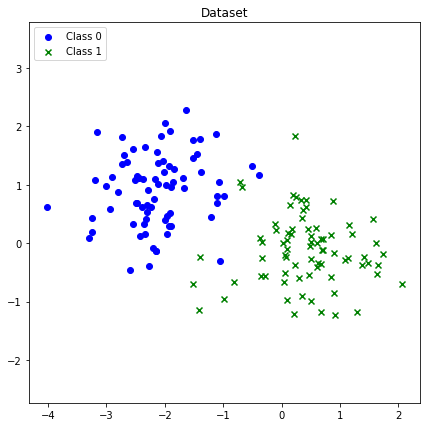

In [ ]:
n_samples = 150
X, y = make_blobs(n_samples=n_samples, centers=[(-2, 1), (0.5,0)], random_state=14, cluster_std=0.60)


#Ploting the dataset without outliers
plt.figure(figsize=(7,7))
fig=plt.gcf()
  
fig.set_facecolor('white')
plt.scatter(X[y==0,0], X[y==0,1], c='b', marker="o", label='Class 0')
plt.scatter(X[y==1,0], X[y==1,1], c='g', marker="x", label='Class 1')
plt.legend(loc='upper left')
plt.axis('equal')

plt.title("Dataset")
plt.show()



##  Pool-Based Active Learning : Steps

<br>We start with some labeled data points (train dataset). There is a large pool of unlabeled data points. These unlabeled data points have to be labeled and added to the train dataset to create the model. However, instead of labeling all the data points from the pool, we will label only a small number of them in active learning, but, still get a good performance.

1. Given labeled data (`train dataset`) and a pool of unlabeled data 
2. A model /learner /classifier is selected and trained on the labeled data
3. The Learner chooses a data point sequentially from the pool and queries the teacher/user for it's label
<br> `Uncertainity Sampling` is the method by which the learner picks the unlabeled data point to be queried. The usual strategy is to assign a measure of uncertainty to each remaining unlabeled points, and select the label of the point with most uncertainty.
4. This data point with the highest uncertainity score is then added to the train dataset and the model is trained on the data, steps 3-4 are repeated
5. Stopping criteria could be the number of instances queried, another could be the number of iterations of steps 3 and 4, you can also stop after the performance does not improve significantly above a certain threshold.

In this notebook:
* Model :- `SVM`
* Uncertrainity Sampling Technique :-
 The idea is that the samples the learner is most uncertain about provide the greatest insight into the underlying data distribution.
For SVM an intuitive way to think about this would be if a data point is closer to the decision boundary it has a higher uncertainity score and it is has a lower uncertainity score if the data point is farther from the decision boundary no matter which side of the decision boundary the point is on. 






## Learner/Model :SVM

Trained with all the data points

We train a Linear SVM kernel on the entire data to understand the SVM model that we would get when using all the data. Since this is a linear SVM model, the decision boundary (the boundary separating the two classes) will be a straight line. 

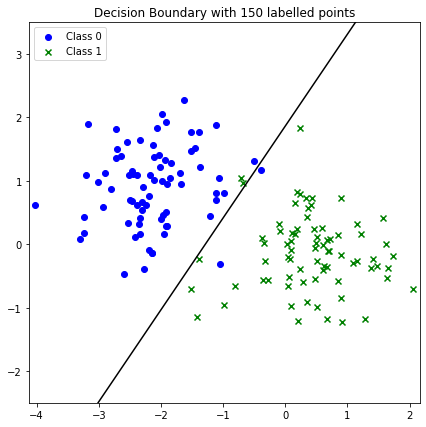

In [ ]:




y_pred = svm.SVC(kernel='linear', C=100).fit(X, y)
x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    

x_vec=np.linspace(x_min,x_max)

decision_boundary=-(y_pred.coef_[0][0]/y_pred.coef_[0][1])* x_vec - y_pred.intercept_/y_pred.coef_[0][1]
plt.figure(figsize=(7,7))
fig=plt.gcf()
  
fig.set_facecolor('white')
plt.plot(x_vec,decision_boundary,color='black')
#Ploting the dataset with outliers

plt.scatter(X[y==0,0], X[y==0,1], c='b', marker="o", label='Class 0')
plt.scatter(X[y==1,0], X[y==1,1], c='g', marker="x", label='Class 1')
plt.title("Decision Boundary with {} labelled points".format(X.shape[0]))
plt.legend(loc='upper left')
plt.xlim(x_min,x_max)
plt.ylim(-2.5,3.5)
plt.show()




###Split the dataset into two parts
- pool (80%) : Of the pool dataset, consider the first 10 indices to be labelled data (i.e initial train dataset),<br> and remaining to be unlabelled data.
- test (20%) : We can check the performance of the model based on the test data



In [ ]:


## Split the Dataset into two parts - pool and test
X_pool, X_test, y_pool, y_test = train_test_split(X, y, test_size=0.2, random_state=1)



#We take the first 10 indices/data points of the pool as the initial train data 
#and the rest 70 points as the unlabelled samples.
n_labelled=10
train_indexes = list(range(n_labelled))
unknown_indexes = list(range(n_labelled, 80))

X_train = X_pool[train_indexes]
y_train = y_pool[train_indexes]



def highest_uncertainity(clf, unknown_indexes):
  '''
  For a linear SVM, the magnitude of decision_function is proportional to the distance of the data point 
  to the separating hyperplane. The function determines the points closest to the decision boundary

  Input:

  -clf : classifier (trained SVM model); 
  -unknown_indexes: indexes from the dataset that are the unlabelled/unknown pool

  Output:
  The function returns the index of the unlabeled data point which is closest to the separating hyperplane

  '''
  ind = np.argmin(np.abs( 
      list(clf.decision_function(X_pool[unknown_indexes]) )
      ))
  return unknown_indexes[ind]

def plot_svm(clf, train_indexes, unknown_indexes, new_index = False, title = False):
  '''
  The function, plot_svm, is used to plot the following:
  Plots SVM decision boundary, the data points from the train data according to their class, and the data points in the unknown pool of samples.
  
  Input:

  clf:- classifier (trained SVM model).
  train_indexes:- Indexes of the dataset that are the train data points.
  unknown_indexes:- Indexes of the dataset that are the unlabelled pool data points.
  title:- The title of the plot.
  new_index:- This is the index of point with highest uncertainity in the unlabelled pool`

  Output:

  Plot all the unlabelled points from the pool in black. 
  Plot all the points from the train data in different colours as per their class labels.
  Plot the decision boundary of the model based on labelled trained data in magenta 
  Plot the decision boundary of the model trained on the whole dataset in green
  plot the new_index point, that is, point with highest uncertainity (yellow star).

  '''
  X_train = X_pool[train_indexes]
  y_train = y_pool[train_indexes]

  X_unk = X_pool[unknown_indexes]

  if new_index:
        X_new = X_pool[new_index]

  a, b, c = clf.coef_[0, 0], clf.coef_[0, 1], clf.intercept_
  # Straight Line Formula
  # a*x + b*y + c = 0
  # y = -(a*x + c)/b


  d_b=-(a/b)*x_vec-(c/b)

  plt.figure(figsize=(7,7))
  fig=plt.gcf()
  fig.set_facecolor('white')

  plt.scatter(X_unk[:,0], X_unk[:,1], c='k', marker = '.', label="Unlabeled")    
  plt.scatter(X_train[y_train==0,0], X_train[y_train==0,1], c='b', marker="o", label='Class 0')
  plt.scatter(X_train[y_train==1,0], X_train[y_train==1,1], c='g', marker="x", label='Class 1')


  plt.plot(x_vec, d_b, c='m',label="Predicted decision boundary")
  plt.plot(x_vec, decision_boundary, '--', c='g', label="Actual decision boundary")

  if new_index:
      plt.scatter(X_new[0], X_new[1], c='y', marker="*", s=125, label="Most ambiguous point")

  if title:
      plt.title(title)
  
  plt.xlabel("Feature 1")
  plt.ylabel("Feature 2")
  plt.xlim(x_min,x_max)
  plt.ylim(-2.5,3.5)

  plt.gca().set_aspect('equal', adjustable='box')
  plt.gca().legend(loc='center left', bbox_to_anchor=(1, 0.5))




Button(description='Query Next Point', style=ButtonStyle())

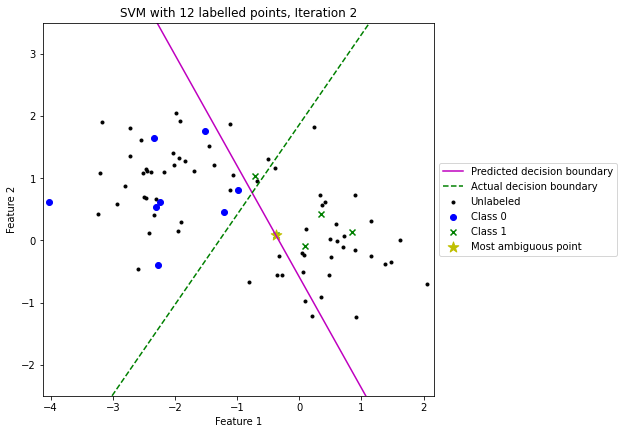

In [ ]:

#We take the first 10 indexes/data points of the pool as the initial train data 
#and the rest 70 points as the unlabelled samples.
n_labelled=10
train_indexes = list(range(n_labelled))
unknown_indexes = list(range(n_labelled, 80))

X_train = X_pool[train_indexes]
y_train = y_pool[train_indexes]




clf=svm.SVC(kernel='linear', C=100).fit(X_train, y_train)
title="Decision Boundary with {} labelled data points".format(n_labelled)




iter=0

def on_button_clicked(b):

  global iter,train_indexes,unknown_indexes
  
  display.clear_output(wait=True)
  X_train = X_pool[train_indexes]
  y_train = y_pool[train_indexes]
  clf=svm.SVC(kernel='linear', C=100).fit(X_train, y_train)
  title= "SVM with {} labelled points, Iteration {}".format(X_train.shape[0],iter)
  n = highest_uncertainity(clf, unknown_indexes)
  train_indexes.append(n)
  unknown_indexes.remove(n)
  display.display(button)
  plot_svm(clf, train_indexes, unknown_indexes, n, title)
  iter+=1




button = widgets.Button(description="Query Next Point")
output = widgets.Output()
button.on_click(on_button_clicked)
display.display(button)
plot_svm(clf, train_indexes, unknown_indexes,False,title)






